## Packages

In [20]:
from math import log
import operator
import treePlotter
import matplotlib.pyplot as plt
%matplotlib inline

## Input Data
数据集有四个特征 'outlook', 'temperature', 'humidity', 'windy'，
接下来要计算它们的信息增益率，来选择节点的构成方式。

In [21]:
def createDataSet():
    """
    outlook->  0: sunny | 1: overcast | 2: rain
    temperature-> 0: hot | 1: mild | 2: cool
    humidity-> 0: high | 1: normal
    windy-> 0: false | 1: true 
    """
    dataSet = [[0, 0, 0, 0, 'N'], 
               [0, 0, 0, 1, 'N'], 
               [1, 0, 0, 0, 'Y'], 
               [2, 1, 0, 0, 'Y'], 
               [2, 2, 1, 0, 'Y'], 
               [2, 2, 1, 1, 'N'], 
               [1, 2, 1, 1, 'Y']]
    labels = ['outlook', 'temperature', 'humidity', 'windy']
    return dataSet, labels

## 计算熵

In [22]:
def calcShannonEnt(dataSet):
    """
    输入：数据集
    输出：数据集的香农熵
    描述：计算给定数据集的香农熵；熵越大，数据集的混乱程度越大
    """
    numEntries = len(dataSet)
    labelCounts = {}
    for featVec in dataSet:
        currentLabel = featVec[-1]
        if currentLabel not in labelCounts.keys():
            labelCounts[currentLabel] = 0
        labelCounts[currentLabel] += 1      # 数每一类各多少个， {'Y': 4, 'N': 3}
    shannonEnt = 0.0
    for key in labelCounts:
        prob = float(labelCounts[key])/numEntries  # 4/7 3/7
        shannonEnt -= prob * log(prob, 2)
    return shannonEnt

In [23]:
def majorityCnt(classList):
    """
    输入：分类类别列表
    输出：子节点的分类
    描述：数据集已经处理了所有属性，但是类标签依然不是唯一的，
          采用多数判决的方法决定该子节点的分类
    """
    classCount = {}
    for vote in classList:
        if vote not in classCount.keys():
            classCount[vote] = 0
        classCount[vote] += 1
    sortedClassCount = sorted(classCount.iteritems(), key=operator.itemgetter(1), reversed=True)
    return sortedClassCount[0][0]

## 选择最大的gain ratio对应的feature

In [24]:
def chooseBestFeatureToSplit(dataSet):
    """
    输入：数据集
    输出：最好的划分维度
    描述：选择最好的数据集划分维度
    """
    numFeatures = len(dataSet[0]) - 1                 #feature个数
    baseEntropy = calcShannonEnt(dataSet)             #整个dataset的熵
    bestInfoGainRatio = 0.0
    bestFeature = -1
    for i in range(numFeatures):
        featList = [example[i] for example in dataSet]  #每个feature的list
        uniqueVals = set(featList)                      #每个list的唯一值集合                 
        newEntropy = 0.0
        splitInfo = 0.0
        for value in uniqueVals:
            subDataSet = splitDataSet(dataSet, i, value)  #每个唯一值对应的剩余feature的组成子集
            prob = len(subDataSet)/float(len(dataSet))
            newEntropy += prob * calcShannonEnt(subDataSet)
            splitInfo += -prob * log(prob, 2)
        infoGain = baseEntropy - newEntropy              #这个feature的infoGain
        if (splitInfo == 0): # fix the overflow bug
            continue
        infoGainRatio = infoGain / splitInfo             #这个feature的infoGainRatio      
        if (infoGainRatio > bestInfoGainRatio):          #选择最大的gain ratio
            bestInfoGainRatio = infoGainRatio
            bestFeature = i                              #选择最大的gain ratio对应的feature
    return bestFeature

## 划分数据，为下一层计算准备

In [25]:
def splitDataSet(dataSet, axis, value):
    """
    输入：数据集，选择维度，选择值
    输出：划分数据集
    描述：按照给定特征划分数据集；去除选择维度中等于选择值的项
    """
    retDataSet = []
    for featVec in dataSet:
        if featVec[axis] == value:                      #只看当第i列的值＝value时的item
            reduceFeatVec = featVec[:axis]              #featVec的第i列给除去
            reduceFeatVec.extend(featVec[axis+1:])
            retDataSet.append(reduceFeatVec)            
    return retDataSet


## 多重字典构建树

In [26]:
def createTree(dataSet, labels):
    """
    输入：数据集，特征标签
    输出：决策树
    描述：递归构建决策树，利用上述的函数
    """
    classList = [example[-1] for example in dataSet]         # ['N', 'N', 'Y', 'Y', 'Y', 'N', 'Y']
    if classList.count(classList[0]) == len(classList):
        # classList所有元素都相等，即类别完全相同，停止划分
        return classList[0]                                  #splitDataSet(dataSet, 0, 0)此时全是N，返回N
    if len(dataSet[0]) == 1:                                 #[0, 0, 0, 0, 'N'] 
        # 遍历完所有特征时返回出现次数最多的
        return majorityCnt(classList)
    bestFeat = chooseBestFeatureToSplit(dataSet)             #0－> 2   
        # 选择最大的gain ratio对应的feature
    bestFeatLabel = labels[bestFeat]                         #outlook -> windy     
    myTree = {bestFeatLabel:{}}                   
        #多重字典构建树{'outlook': {0: 'N'
    del(labels[bestFeat])                                    #['temperature', 'humidity', 'windy'] -> ['temperature', 'humidity']        
    featValues = [example[bestFeat] for example in dataSet]  #[0, 0, 1, 2, 2, 2, 1]     
    uniqueVals = set(featValues)
    for value in uniqueVals:
        subLabels = labels[:]                                #['temperature', 'humidity', 'windy']
        myTree[bestFeatLabel][value] = createTree(splitDataSet(dataSet, bestFeat, value), subLabels)
            # 划分数据，为下一层计算准备
    return myTree

## 可视化决策树的结果

[[0, 0, 0, 0, 'N'], [0, 0, 0, 1, 'N'], [1, 0, 0, 0, 'Y'], [2, 1, 0, 0, 'Y'], [2, 2, 1, 0, 'Y'], [2, 2, 1, 1, 'N'], [1, 2, 1, 1, 'Y']]
['outlook', 'temperature', 'humidity', 'windy']
{'outlook': {0: 'N', 1: 'Y', 2: {'windy': {0: 'Y', 1: 'N'}}}}
3


AttributeError: 'int' object has no attribute 'keys'

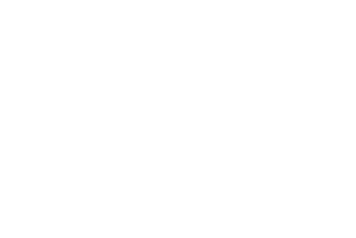

In [33]:
dataSet, labels = createDataSet()
labels_tmp = labels[:]
desicionTree = createTree(dataSet, labels_tmp)
print dataSet
print labels
print desicionTree
desicionTree = \
{'id': 3, 'children': [{'id': 2, 'children': [{'id': 1}, {'id': 4}]}, {'id': 5}]}
# {'\xe7\x9b\xb4\xe9\x80\x9a\xe8\xbd\xa6\xe9\x94\x80\xe5\x94\xae\xe9\x87\x91\xe9\xa2\x9d\xe6\x95\xb0\xe6\x8d\xae\xe5\x88\x86\xe6\x9e\x90': {41L: {41: {42L: {42: {44L: {44: {46L: {46: {48L: {48: '\xe6\x9c\xac\xe6\x9c\x9f\xe6\x96\xb0\xe5\xa2\x9e\xe6\x8a\x95\xe6\x94\xbe\xe5\xae\xa2\xe6\x88\xb7'}, 49L: {49: '\xe6\x9c\xac\xe6\x9c\x9f\xe4\xb8\x8b\xe7\xba\xbf\xe5\xae\xa2\xe6\x88\xb7'}, 50L: {50: '\xe5\x9f\xba\xe6\x9c\x9f\xe6\x9c\xac\xe6\x9c\x9f\xe6\x8a\x95\xe6\x94\xbe\xe5\xae\xa2\xe6\x88\xb7'}}}, 47L: {47: '\xe5\x81\x9c\xe6\xad\xa2'}}}, 45L: {45: '\xe5\x81\x9c\xe6\xad\xa2'}}}, 43L: {43: '\xe5\x81\x9c\xe6\xad\xa2'}}}, 51L: {51: {52L: {52: {54L: {54: {56L: {56: {58L: {58: '\xe6\x9c\xac\xe6\x9c\x9f\xe6\x96\xb0\xe5\xa2\x9e\xe6\x8a\x95\xe6\x94\xbe\xe5\xae\xa2\xe6\x88\xb7'}, 59L: {59: '\xe6\x9c\xac\xe6\x9c\x9f\xe4\xb8\x8b\xe7\xba\xbf\xe5\xae\xa2\xe6\x88\xb7'}, 60L: {60: '\xe5\x9f\xba\xe6\x9c\x9f\xe6\x9c\xac\xe6\x9c\x9f\xe6\x8a\x95\xe6\x94\xbe\xe5\xae\xa2\xe6\x88\xb7'}}}, 57L: {57: '\xe5\x81\x9c\xe6\xad\xa2'}}}, 55L: {55: '\xe5\x81\x9c\xe6\xad\xa2'}}}, 53L: {53: '\xe5\x81\x9c\xe6\xad\xa2'}}}, 15L: {15: {16L: {16: {18L: {18: {20L: {20: {24L: {24: '\xe6\x9c\xac\xe6\x9c\x9f\xe6\x96\xb0\xe5\xa2\x9e\xe6\x8a\x95\xe6\x94\xbe\xe5\xae\xa2\xe6\x88\xb7'}, 25L: {25: '\xe6\x9c\xac\xe6\x9c\x9f\xe4\xb8\x8b\xe7\xba\xbf\xe5\xae\xa2\xe6\x88\xb7'}, 26L: {26: {31L: {31: {32L: {32: {34L: {34: {36L: {36: {38L: {38: '\xe6\x9c\xac\xe6\x9c\x9f\xe4\xb8\x8b\xe7\xba\xbf'}, 39L: {39: '\xe5\x9f\xba\xe6\x9c\x9f\xe6\x9c\xac\xe6\x9c\x9f\xe6\x8a\x95\xe6\x94\xbe'}}}, 37L: {37: '\xe5\x81\x9c\xe6\xad\xa2\xe5\x8f\xaf\xe6\x8f\x90\xe5\x8d\x87\xe7\x82\xb9\xe6\x9f\xa5\xe6\x89\xbe'}}}, 35L: {35: '\xe5\xae\xa2\xe6\x88\xb7\xe7\xab\x9e\xe4\xbb\xb7\xe9\x87\x8f\xe4\xb8\x8b\xe9\x99\x8d\xef\xbc\x8c\xe5\xbb\xba\xe8\xae\xae\xe6\x8b\x93\xe5\xb1\x95\xe5\x85\xb3\xe9\x94\xae\xe8\xaf\x8d\xef\xbc\x8c\xe6\x81\xa2\xe5\xa4\x8d\xe5\x90\x8e\xe9\xa2\x84\xe8\xae\xa1\xe6\x94\xb6\xe5\x85\xa5\xe5\x8f\xaf\xe6\x8f\x90\xe5\x8d\x87%s\xe5\x85\x83'}}}, 33L: {33: '\xe5\x81\x9c\xe6\xad\xa2'}}}}}}}, 21L: {21: '\xe5\x81\x9c\xe6\xad\xa2'}}}, 19L: {19: '\xe5\x81\x9c\xe6\xad\xa2'}}}, 17L: {17: '\xe5\x81\x9c\xe6\xad\xa2'}}}}}
treePlotter.createPlot(desicionTree)

## 对新数据进行分类

In [28]:
def classify(inputTree, featLabels, testVec):
    """
    输入：决策树，分类标签，测试数据
    输出：决策结果
    描述：跑决策树
    """

    firstStr = list(inputTree.keys())[0]                       # ['outlook'], outlook
    secondDict = inputTree[firstStr]                           # {0: 'N', 1: 'Y', 2: {'windy': {0: 'Y', 1: 'N'}}}
    featIndex = featLabels.index(firstStr)                     # outlook所在的列序号0 
    for key in secondDict.keys():                              # secondDict.keys()＝[0, 1, 2]
        if testVec[featIndex] == key:                          # secondDict[key]＝N
            # test向量的当前feature是哪个值，就走哪个树杈
            if type(secondDict[key]).__name__ == 'dict':       # type(secondDict[key]).__name__＝str
                # 如果secondDict[key]仍然是字典，则继续向下层走
                classLabel = classify(secondDict[key], featLabels, testVec)
            else:
                # 如果secondDict[key]已经只是分类标签了，则返回这个类别标签
                classLabel = secondDict[key]
    return classLabel

In [29]:
# Create Test Set
def createTestSet():
    """
    outlook->  0: sunny | 1: overcast | 2: rain
    temperature-> 0: hot | 1: mild | 2: cool
    humidity-> 0: high | 1: normal
    windy-> 0: false | 1: true 
    """
    testSet = [[0, 1, 0, 0], 
               [0, 2, 1, 0], 
               [2, 1, 1, 0], 
               [0, 1, 1, 1], 
               [1, 1, 0, 1], 
               [1, 0, 1, 0], 
               [2, 1, 0, 1]]
    return testSet

In [30]:
inputTree = desicionTree
featLabels = ['outlook', 'temperature', 'humidity', 'windy']
testVec = [0, 1, 0, 0]
classify(inputTree, featLabels, testVec)

ValueError: '\xe7\x9b\xb4\xe9\x80\x9a\xe8\xbd\xa6\xe9\x94\x80\xe5\x94\xae\xe9\x87\x91\xe9\xa2\x9d\xe6\x95\xb0\xe6\x8d\xae\xe5\x88\x86\xe6\x9e\x90' is not in list

## 对多条新数据进行分类

In [19]:
def classifyAll(inputTree, featLabels, testDataSet):
    """
    输入：决策树，分类标签，测试数据集
    输出：决策结果
    描述：跑决策树
    """
    classLabelAll = []
    for testVec in testDataSet:               #逐个item进行分类判断
        classLabelAll.append(classify(inputTree, featLabels, testVec))
    return classLabelAll

In [21]:
testSet = createTestSet()
print('classifyResult:\n', classifyAll(desicionTree, labels, testSet))

('classifyResult:\n', ['N', 'N', 'Y', 'N', 'Y', 'Y', 'N'])
